In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
import seaborn as sb
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tqdm import tqdm
import cv2
import random

In [2]:
base_skin_dir = os.path.join('..', 'input')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary
all_image_path = glob(os.path.join(base_skin_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in all_image_path}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [3]:
# def compute_img_mean_std(image_paths):
#     """
#         computing the mean and std of three channel on the whole dataset,
#         first we should normalize the image from 0-255 to 0-1
#     """

#     img_h, img_w = 224, 224
#     imgs = []
#     means, stdevs = [], []

#     for i in tqdm(range(len(image_paths))):
#         img = cv2.imread(image_paths[i])
#         img = cv2.resize(img, (img_h, img_w))
#         imgs.append(img)

#     imgs = np.stack(imgs, axis=3)
#     print(imgs.shape)

#     imgs = imgs.astype(np.float32) / 255.

#     for i in range(3):
#         pixels = imgs[:, :, i, :].ravel()  # resize to one row
#         means.append(np.mean(pixels))
#         stdevs.append(np.std(pixels))

#     means.reverse()  # BGR --> RGB
#     stdevs.reverse()

#     print("normMean = {}".format(means))
#     print("normStd = {}".format(stdevs))
#     return means,stdevs
# # norm_mean,norm_std = compute_img_mean_std(all_image_path)

In [4]:
df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# new col

df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,..\input\HAM10000_images_part_1\ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,..\input\HAM10000_images_part_1\ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,..\input\HAM10000_images_part_1\ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,..\input\HAM10000_images_part_1\ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,..\input\HAM10000_images_part_2\ISIC_0031633.jpg,Benign keratosis-like lesions,2


### Nan 

In [5]:
df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
dataset           0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [6]:
df['age'].fillna((df['age'].mean()), inplace=True)

In [7]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
dataset          0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

## Exploring the data

<AxesSubplot: >

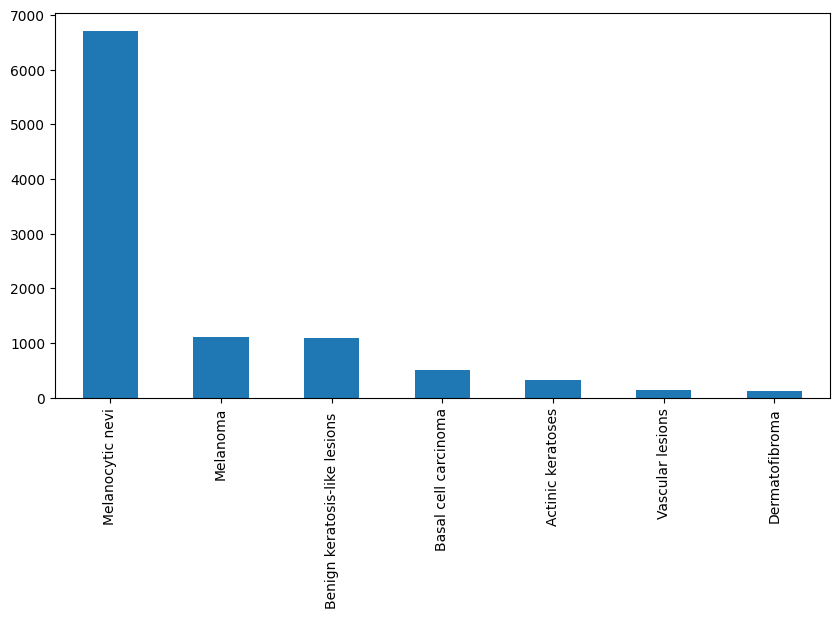

In [8]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

<AxesSubplot: >

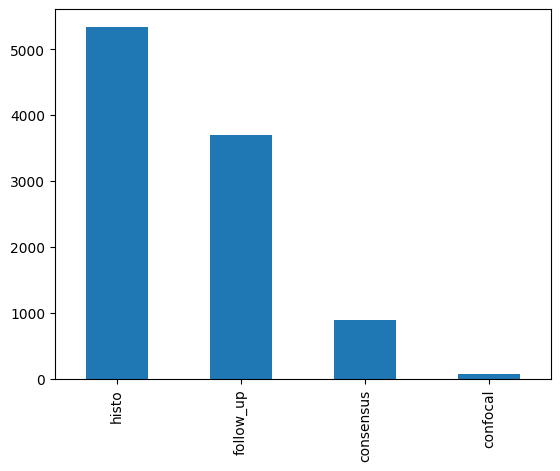

In [9]:
df['dx_type'].value_counts().plot(kind='bar')

<AxesSubplot: >

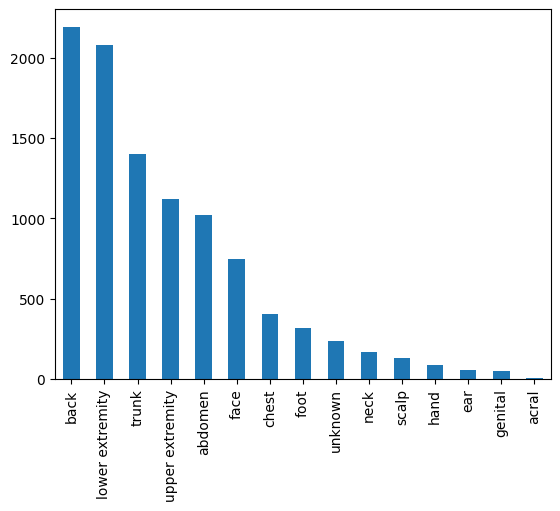

In [10]:
df['localization'].value_counts().plot(kind='bar')

<AxesSubplot: >

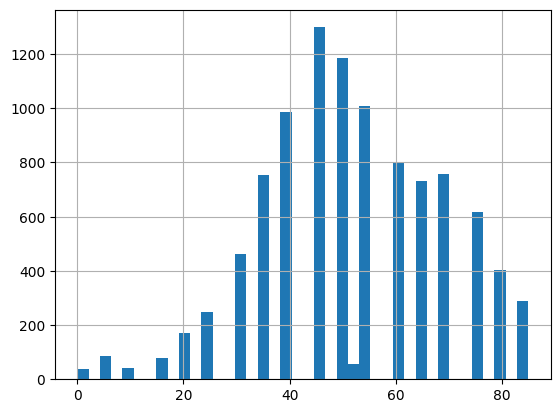

In [11]:
df['age'].hist(bins=40)

<AxesSubplot: >

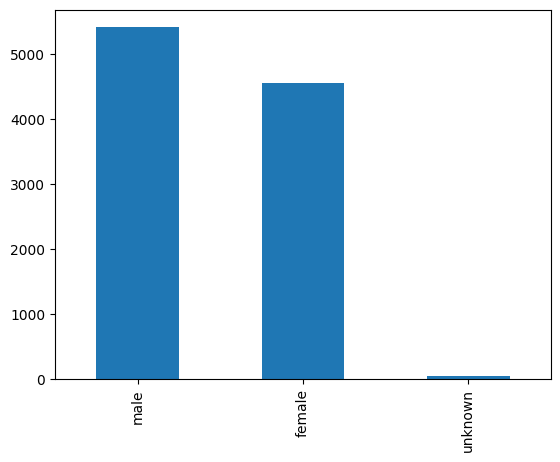

In [12]:
df['sex'].value_counts().plot(kind='bar')

In [13]:
# this will tell us how many images are associated with each lesion_id
df_undup = df.groupby('lesion_id').count()
# now we filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1,1


In [14]:
def check_dup(id):
    if id in list(df_undup['lesion_id']):
        return 'undup'
    else:
        return 'dup'
df['duplicated?'] = df['lesion_id'].apply(check_dup)
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx,duplicated?
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,..\input\HAM10000_images_part_1\ISIC_0027419.jpg,Benign keratosis-like lesions,2,dup
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,..\input\HAM10000_images_part_1\ISIC_0025030.jpg,Benign keratosis-like lesions,2,dup
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,..\input\HAM10000_images_part_1\ISIC_0026769.jpg,Benign keratosis-like lesions,2,dup
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,..\input\HAM10000_images_part_1\ISIC_0025661.jpg,Benign keratosis-like lesions,2,dup
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,..\input\HAM10000_images_part_2\ISIC_0031633.jpg,Benign keratosis-like lesions,2,dup


In [15]:
df['duplicated?'].value_counts()

undup    5514
dup      4501
Name: duplicated?, dtype: int64

In [16]:
df_chop = df.loc[(df['cell_type'] != 'Melanocytic nevi') | (df['duplicated?'] == 'undup')]

In [17]:
df_chop['cell_type'].value_counts()

Melanocytic nevi                  4415
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64

In [18]:
row_count = 3200
for index, row in df_chop.iterrows():
    if (row_count > 0) and (row['cell_type'] == 'Melanocytic nevi') :
        df_chop = df_chop.drop(index)
        row_count -= 1
df_chop['cell_type'].value_counts()

Melanocytic nevi                  1215
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64

In [19]:
df_undup = df_chop[df_chop['duplicated?'] == 'undup']
df_undup.shape


(2314, 12)

In [20]:
df_undup['cell_type'].value_counts()

Melanocytic nevi                  1215
Benign keratosis-like lesions      440
Melanoma                           230
Basal cell carcinoma               175
Actinic keratoses                  151
Vascular lesions                    64
Dermatofibroma                      39
Name: cell_type, dtype: int64

In [21]:
_, val = train_test_split(df_undup, test_size=0.2, stratify=df_undup['cell_type_idx'])

In [22]:
val['cell_type'].value_counts()

Melanocytic nevi                  243
Benign keratosis-like lesions      88
Melanoma                           46
Basal cell carcinoma               35
Actinic keratoses                  30
Vascular lesions                   13
Dermatofibroma                      8
Name: cell_type, dtype: int64

In [23]:
def train_val_label(id):
    if id in list(val['image_id']):
        return 'value'
    else:
        return 'train'
df_chop['train_value'] = df_chop['image_id'].apply(train_val_label)
train = df_chop[df_chop['train_value'] == 'train']
train['cell_type'].value_counts()

Melanoma                          1067
Benign keratosis-like lesions     1011
Melanocytic nevi                   972
Basal cell carcinoma               479
Actinic keratoses                  297
Vascular lesions                   129
Dermatofibroma                     107
Name: cell_type, dtype: int64

In [24]:
img_count = train['cell_type_idx'].value_counts()

In [25]:
print(img_count[0])
Max_img_count = 0
for i in range(7):
    print(i, img_count[i])
    if img_count[i] > img_count[Max_img_count]:
        Max_img_count = i
print(Max_img_count)

297
0 297
1 479
2 1011
3 107
4 972
5 1067
6 129
5


In [26]:
img_count[Max_img_count]

1067

In [27]:
[img_count[Max_img_count]//img_count[i]-1 for i in range(7)]

[2, 1, 0, 8, 0, 0, 7]

### Solve imbalance

In [28]:
df_chop['cell_type_idx'].value_counts()

4    1215
5    1113
2    1099
1     514
0     327
6     142
3     115
Name: cell_type_idx, dtype: int64

In [29]:
df_chop['cell_type_idx'].value_counts()[0]

327

In [30]:
def fill(img, h, w):
    img = cv2.resize(img, (w, h), cv2.INTER_CUBIC)
    return img

def horizontal_shift(img, ratio=0.0):
    if ratio > 1 or ratio < 0:
        return img
    ratio = random.uniform(-ratio, ratio)
    h, w = img.shape[:2]
    shift = w*ratio
    if ratio > 0:
        img = img[:, :int(w - shift), :]
    if ratio < 0:
        img = img[:, int(-1*shift):, :]
    img = fill(img, h, w)
    return img

def vertical_shift(img, ratio=0.0):
    if ratio > 1 or ratio < 0:
        return img
    ratio = random.uniform(-ratio, ratio)
    h, w = img.shape[:2]
    shift = h*ratio
    if ratio > 0:
        img = img[:int(h - shift), :, :]
    if ratio < 0:
        img = img[int(-1*shift):, :, :]
    img = fill(img, h, w)
    return img

def shift_brightness(img, low, high):
    value = random.uniform(low, high)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype=np.float64)
    # hsv[:, :, 1] = hsv[:,:,1]*value
    # hsv[:, :, 1][hsv[:,:,1]>255] = 255
    hsv[:, :, 2]= hsv[:, :, 2]*value
    hsv[:, :, 2][hsv[:,:,2]>255] = 255
    hsv = np.array(hsv, dtype=np.uint8)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return img

def zoom(img, ratio, fix_rate):
    if ratio > 1 or ratio < 0:
        return img
    if fix_rate:
        ratio = ratio
    else:
        ratio = random.uniform(ratio, 1)
    h, w = img.shape[:2]
    zoom_h = int(h*ratio)
    zoom_w = int(w*ratio)
    top_left_h = 0
    top_left_w = 0
    if fix_rate:
        top_left_h = (h-zoom_h)//2
        top_left_w = (w-zoom_w)//2
    else:
        top_left_h = random.randint(0, h-zoom_h)
        top_left_w = random.randint(0, w-zoom_w)
    img = img[top_left_h:top_left_h+zoom_h, top_left_w:top_left_w+zoom_w, :]
    return fill(img, h, w)

def horizontal_flip(img):
    return cv2.flip(img, 1)

def vertical_flip(img):
    return cv2.flip(img, 0)

def rotation(img, angle):
    h, w = img.shape[:2]
    angle = random.randint(-angle, angle)
    return cv2.warpAffine(img, cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1), (w,h))

def random_aug_once(img, rate=0.4):
    # im = cv2.imread(path)
    im = img
    rotated = False
    if random.uniform(0,1) < rate:
        im = rotation(im, 90)
        im = zoom(im, 0.65, True)
        rotated = True
    if random.uniform(0, 1) < rate:
        im = horizontal_shift(im, 0.4)
    if random.uniform(0, 1) < rate:
        im = vertical_shift(im, 0.4)
    if random.uniform(0, 1) < rate:
        im = shift_brightness(im, 0.5, 2)
    if not rotated:
        if (random.uniform(0,1) < rate):
            im = zoom(im, 0.6, False)
    else:
        if (random.uniform(0,1) < rate):
            im = zoom(im, 0.8, False)
    if random.uniform(0,1) < rate:
        im = horizontal_flip(im)
    if random.uniform(0,1) < rate:
        im = vertical_flip(im)

    return im

In [31]:
aug_rate = [img_count[Max_img_count]//img_count[i]-1 for i in range(7)]
# aug_rate = [2, 1, 0, 8, 0, 0, 7]
df = df_chop
count = 0
for i in range(7):
    for index, row in train.iterrows():
        if row['cell_type_idx'] == i:
            original_img = cv2.imread(row['path'])
            for rate in range(aug_rate[i]): # row['cell_type_idx']
                augmented_img = random_aug_once(original_img)
                new_image_id = row['image_id']+'_cp{count}'.format(count=rate)
                new_path = os.path.join('..', 'input', 'Augmented_imgs', new_image_id+'.jpg')
                cv2.imwrite(new_path, augmented_img)
                temp_df = [row['lesion_id'], new_image_id, row['dx'], row['dx_type'], row['age'], row['sex'], row['localization'], row['dataset'], new_path, row['cell_type'], row['cell_type_idx'], row['duplicated?'], row['train_value']]
                df.loc[len(df)] = temp_df
                count += 1
df.to_csv('aug_HAM10000_metadata.csv', index=False)
print(count)

2832


In [32]:
aug_rate[6]

7

In [33]:
df_chop.count()

lesion_id        6176
image_id         6176
dx               6176
dx_type          6176
age              6176
sex              6176
localization     6176
dataset          6176
path             6176
cell_type        6176
cell_type_idx    6176
duplicated?      6176
train_value      6176
dtype: int64

In [34]:
train['cell_type_idx'].value_counts()

5    1067
2    1011
4     972
1     479
0     297
6     129
3     107
Name: cell_type_idx, dtype: int64

In [36]:
df['cell_type'].value_counts()

Melanocytic nevi                  1214
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               993
Actinic keratoses                  921
Dermatofibroma                     693
Vascular lesions                   143
Name: cell_type, dtype: int64

In [37]:
train['cell_type'].value_counts()

Melanoma                          1067
Benign keratosis-like lesions     1011
Melanocytic nevi                   972
Basal cell carcinoma               479
Actinic keratoses                  297
Vascular lesions                   129
Dermatofibroma                     107
Name: cell_type, dtype: int64